In [79]:
# Configuration - Set crop type and model variant here
crop_type = "soybean"  # Change to "corn" or "soybean" as needed
weatherformer_variant = "weatherformersinusoid"  # Change to "weatherformer" or "weatherformersinusoid" as needed
model_display_name = 'VITA'  # Both weatherformer variants show as WeatherFormer

# Extreme years for each crop (used for cross-validation)
EXTREME_YEARS = {
    "corn": [2002, 2004, 2009, 2012, 2014],
    "soybean": [2003, 2004, 2009, 2012, 2016],
}

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# Comprehensive rcParams for publication-ready neurips paper - SET ONCE
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 24,
    'axes.titlesize': 26,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 12,
    'lines.markeredgewidth': 2.5,
    'legend.frameon': False,
    'figure.dpi': 300,
    'font.weight': 'normal',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'grid.alpha': 0.3,
    'grid.linewidth': 1,
    'figure.figsize': (20, 6),
    'axes.grid': True,
})

print(f"Crop type set to: {crop_type}")
print(f"WeatherFormer variant set to: {weatherformer_variant}")


Crop type set to: soybean
WeatherFormer variant set to: weatherformersinusoid


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data using the crop_type and weatherformer_variant parameters
bert_data = pd.read_csv(f'data/grid_search_bert_pretrained_{crop_type}.tsv', sep='\t')
weatherformer_data = pd.read_csv(f'data/grid_search_{weatherformer_variant}_pretrained_{crop_type}.tsv', sep='\t')
gnnrnn_data = pd.read_csv(f'data/grid_search_gnnrnn_pretrained_{crop_type}.tsv', sep='\t')

# Extract R² values (removing ± error part)
bert_data['r2'] = bert_data['year_15_r2'].str.split(' ± ').str[0].astype(float)
weatherformer_data['r2'] = weatherformer_data['year_15_r2'].str.split(' ± ').str[0].astype(float)
gnnrnn_data['r2'] = gnnrnn_data['year_15_r2'].str.split(' ± ').str[0].astype(float)

print("Data loaded successfully!")
print(f"BERT data shape: {bert_data.shape}")
print(f"WeatherFormer data shape: {weatherformer_data.shape}")
print(f"GNN-RNN data shape: {gnnrnn_data.shape}")

# Display first few rows
print("\nBERT data preview:")
print(bert_data[['batch_size', 'init_lr', 'beta', 'r2']].head())
print("\nWeatherFormer data preview:")
print(weatherformer_data[['batch_size', 'init_lr', 'beta', 'r2']].head())
print("\nGNN-RNN data preview:")
print(gnnrnn_data[['batch_size', 'init_lr', 'beta', 'r2']].head())


Data loaded successfully!
BERT data shape: (9, 8)
WeatherFormer data shape: (27, 8)
GNN-RNN data shape: (9, 8)

BERT data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.705
1          16  0.00050   0.0  0.701
2          16  0.00100   0.0  0.692
3          32  0.00025   0.0  0.691
4          32  0.00050   0.0  0.697

WeatherFormer data preview:
   batch_size  init_lr    beta     r2
0          16  0.00025  0.0000  0.718
1          16  0.00025  0.0001  0.727
2          16  0.00025  0.0010  0.678
3          16  0.00050  0.0000  0.723
4          16  0.00050  0.0001  0.711

GNN-RNN data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.632
1          16  0.00050   0.0  0.643
2          16  0.00100   0.0  0.624
3          32  0.00025   0.0  0.598
4          32  0.00050   0.0  0.642


In [81]:
# Prepare data for each subplot

# 1. Batch size vs R² (best R² for each batch size per model)
batch_sizes = [16, 32, 64]
batch_bert_r2 = []
batch_weatherformer_r2 = []
batch_gnnrnn_r2 = []

for bs in batch_sizes:
    # BERT: best R² for this batch size
    bert_best = bert_data[bert_data['batch_size'] == bs]['r2'].max()
    batch_bert_r2.append(bert_best)
    
    # WeatherFormer: best R² for this batch size (across all betas)
    wf_best = weatherformer_data[weatherformer_data['batch_size'] == bs]['r2'].max()
    batch_weatherformer_r2.append(wf_best)
    
    # GNN-RNN: best R² for this batch size
    gnnrnn_best = gnnrnn_data[gnnrnn_data['batch_size'] == bs]['r2'].max()
    batch_gnnrnn_r2.append(gnnrnn_best)

# 2. Learning rate vs R² (best R² for each learning rate per model)
learning_rates = [0.00025, 0.0005, 0.001]
lr_bert_r2 = []
lr_weatherformer_r2 = []
lr_gnnrnn_r2 = []

for lr in learning_rates:
    # BERT: best R² for this learning rate
    bert_best = bert_data[bert_data['init_lr'] == lr]['r2'].max()
    lr_bert_r2.append(bert_best)
    
    # WeatherFormer: best R² for this learning rate (across all betas)
    wf_best = weatherformer_data[weatherformer_data['init_lr'] == lr]['r2'].max()
    lr_weatherformer_r2.append(wf_best)
    
    # GNN-RNN: best R² for this learning rate
    gnnrnn_best = gnnrnn_data[gnnrnn_data['init_lr'] == lr]['r2'].max()
    lr_gnnrnn_r2.append(gnnrnn_best)

# 3. Beta vs R² (WeatherFormer only - GNN-RNN only has beta=0.0)
betas = [0.0, 0.0001, 0.001]
beta_weatherformer_r2 = []

for beta in betas:
    # WeatherFormer: best R² for this beta (across all other hyperparams)
    wf_best = weatherformer_data[weatherformer_data['beta'] == beta]['r2'].max()
    beta_weatherformer_r2.append(wf_best)

print("Data prepared for plotting:")
print(f"Batch sizes: {batch_sizes}")
print(f"BERT R² by batch size: {batch_bert_r2}")
print(f"WeatherFormer R² by batch size: {batch_weatherformer_r2}")
print(f"GNN-RNN R² by batch size: {batch_gnnrnn_r2}")
print(f"Learning rates: {learning_rates}")
print(f"BERT R² by learning rate: {lr_bert_r2}")
print(f"WeatherFormer R² by learning rate: {lr_weatherformer_r2}")
print(f"GNN-RNN R² by learning rate: {lr_gnnrnn_r2}")
print(f"Betas: {betas}")
print(f"WeatherFormer R² by beta: {beta_weatherformer_r2}")


Data prepared for plotting:
Batch sizes: [16, 32, 64]
BERT R² by batch size: [0.705, 0.697, 0.701]
WeatherFormer R² by batch size: [0.727, 0.722, 0.714]
GNN-RNN R² by batch size: [0.643, 0.642, 0.647]
Learning rates: [0.00025, 0.0005, 0.001]
BERT R² by learning rate: [0.705, 0.701, 0.698]
WeatherFormer R² by learning rate: [0.727, 0.723, 0.721]
GNN-RNN R² by learning rate: [0.632, 0.643, 0.647]
Betas: [0.0, 0.0001, 0.001]
WeatherFormer R² by beta: [0.723, 0.727, 0.698]


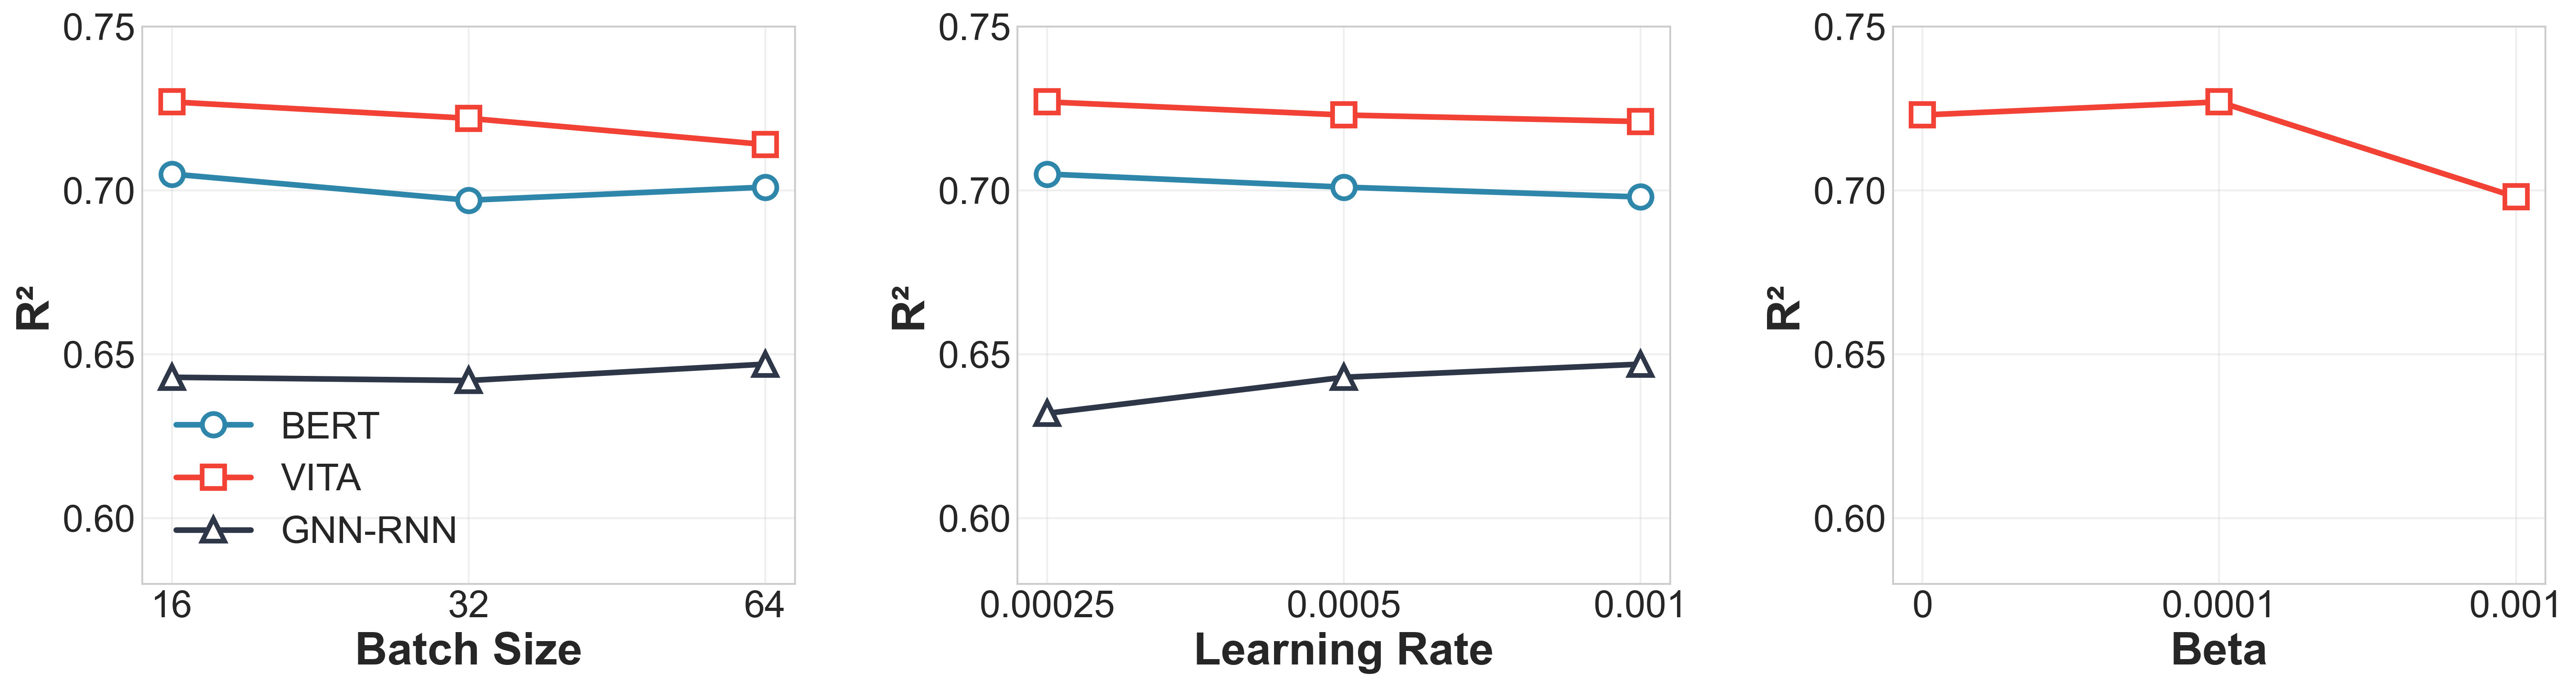

saved as '../data/latex/img/grid_search_soybean.pdf'


In [82]:
# Create the professional neurips-style plot - all styling handled by rcParams
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Define colors and markers for models
colors = {'BERT': '#2E86AB', model_display_name: '#F24236', 'GNN-RNN': '#2D3748'}
markers = {'BERT': 'o', model_display_name: 's', 'GNN-RNN': '^'}

# Plot 1: Batch Size vs R² (legend only here)
x_batch = np.arange(len(batch_sizes))
ax1.plot(x_batch, batch_bert_r2, color=colors['BERT'], marker=markers['BERT'], 
         label='BERT', markerfacecolor='white', markeredgecolor=colors['BERT'])
ax1.plot(x_batch, batch_weatherformer_r2, color=colors[model_display_name], marker=markers[model_display_name], 
         label=model_display_name, markerfacecolor='white', markeredgecolor=colors[model_display_name])
ax1.plot(x_batch, batch_gnnrnn_r2, color=colors['GNN-RNN'], marker=markers['GNN-RNN'], 
         label='GNN-RNN', markerfacecolor='white', markeredgecolor=colors['GNN-RNN'])

ax1.set_xlabel('Batch Size')
ax1.set_ylabel('R²')
ax1.set_xticks(x_batch)
ax1.set_xticklabels(batch_sizes)
ax1.legend(loc='lower left')

# Plot 2: Learning Rate vs R² (no legend)
x_lr = np.arange(len(learning_rates))
ax2.plot(x_lr, lr_bert_r2, color=colors['BERT'], marker=markers['BERT'], 
         markerfacecolor='white', markeredgecolor=colors['BERT'])
ax2.plot(x_lr, lr_weatherformer_r2, color=colors[model_display_name], marker=markers[model_display_name], 
         markerfacecolor='white', markeredgecolor=colors[model_display_name])
ax2.plot(x_lr, lr_gnnrnn_r2, color=colors['GNN-RNN'], marker=markers['GNN-RNN'], 
         markerfacecolor='white', markeredgecolor=colors['GNN-RNN'])

ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('R²')
ax2.set_xticks(x_lr)
ax2.set_xticklabels(['0.00025', '0.0005', '0.001'])

# Plot 3: Beta vs R² (WeatherFormer only, no legend)
x_beta = np.arange(len(betas))
ax3.plot(x_beta, beta_weatherformer_r2, color=colors[model_display_name], marker=markers[model_display_name], 
         markerfacecolor='white', markeredgecolor=colors[model_display_name])

ax3.set_xlabel('Beta')
ax3.set_ylabel('R²')
ax3.set_xticks(x_beta)
ax3.set_xticklabels(['0', '0.0001', '0.001'])


if crop_type == 'soybean':
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0.58, 0.75)
        ax.set_yticks([0.60, 0.65, 0.70, 0.75])

else:
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0.48, 0.75)
        ax.set_yticks([0.50, 0.55, 0.60, 0.65, 0.70, 0.75])

# Create output directory if it doesn't exist
import os
os.makedirs('../data/latex/img', exist_ok=True)

# Adjust layout and save
plt.tight_layout(pad=2.0)
plt.savefig(f'../data/latex/img/grid_search_{crop_type}.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"saved as '../data/latex/img/grid_search_{crop_type}.pdf'")


In [83]:
import json

# Load JSON files for individual R² values
with open(f'data/grid_search_bert_pretrained_{crop_type}.json', 'r') as f:
    bert_json = json.load(f)

with open(f'data/grid_search_{weatherformer_variant}_pretrained_{crop_type}.json', 'r') as f:
    weatherformer_json = json.load(f)

# Find the best performing model for each type based on mean R²
best_bert_config = None
best_bert_r2 = -1
best_weatherformer_config = None
best_weatherformer_r2 = -1

# Find best BERT configuration
for config_name, results in bert_json.items():
    mean_r2 = results['year_15']['mean_r2']
    if mean_r2 > best_bert_r2:
        best_bert_r2 = mean_r2
        best_bert_config = config_name

# Find best WeatherFormer configuration
for config_name, results in weatherformer_json.items():
    mean_r2 = results['year_15']['mean_r2']
    if mean_r2 > best_weatherformer_r2:
        best_weatherformer_r2 = mean_r2
        best_weatherformer_config = config_name

print(f"Best BERT configuration: {best_bert_config}")
print(f"Best BERT mean R²: {best_bert_r2:.3f}")
print(f"Best WeatherFormer configuration: {best_weatherformer_config}")
print(f"Best WeatherFormer mean R²: {best_weatherformer_r2:.3f}")

# Extract individual R² values for the best configurations
best_bert_individual_r2 = bert_json[best_bert_config]['year_15']['individual_r2_values']
best_weatherformer_individual_r2 = weatherformer_json[best_weatherformer_config]['year_15']['individual_r2_values']

print(f"\nBest BERT individual R² values: {best_bert_individual_r2}")
print(f"Best WeatherFormer individual R² values: {best_weatherformer_individual_r2}")


Best BERT configuration: bert_pretrained_soybean_beta_0.0_bs_16_lr_0.00025
Best BERT mean R²: 0.705
Best WeatherFormer configuration: weatherformersinusoid_pretrained_soybean_beta_0.0001_bs_16_lr_0.00025
Best WeatherFormer mean R²: 0.727

Best BERT individual R² values: [0.5100715366716411, 0.6617667723559935, 0.775661974911123, 0.7285652996276953, 0.8478268398239197]
Best WeatherFormer individual R² values: [0.5871269504573595, 0.7112002347619198, 0.8089631747238377, 0.6937977391126908, 0.8360521193017281]


In [84]:
# Increase legend, ticks, and axis labels by 50% for individual plot
plt.rcParams.update({
    'axes.labelsize': 36,      # 24 * 1.5
    'xtick.labelsize': 30,     # 20 * 1.5  
    'ytick.labelsize': 30,     # 20 * 1.5
    'legend.fontsize': 30,     # 20 * 1.5
})


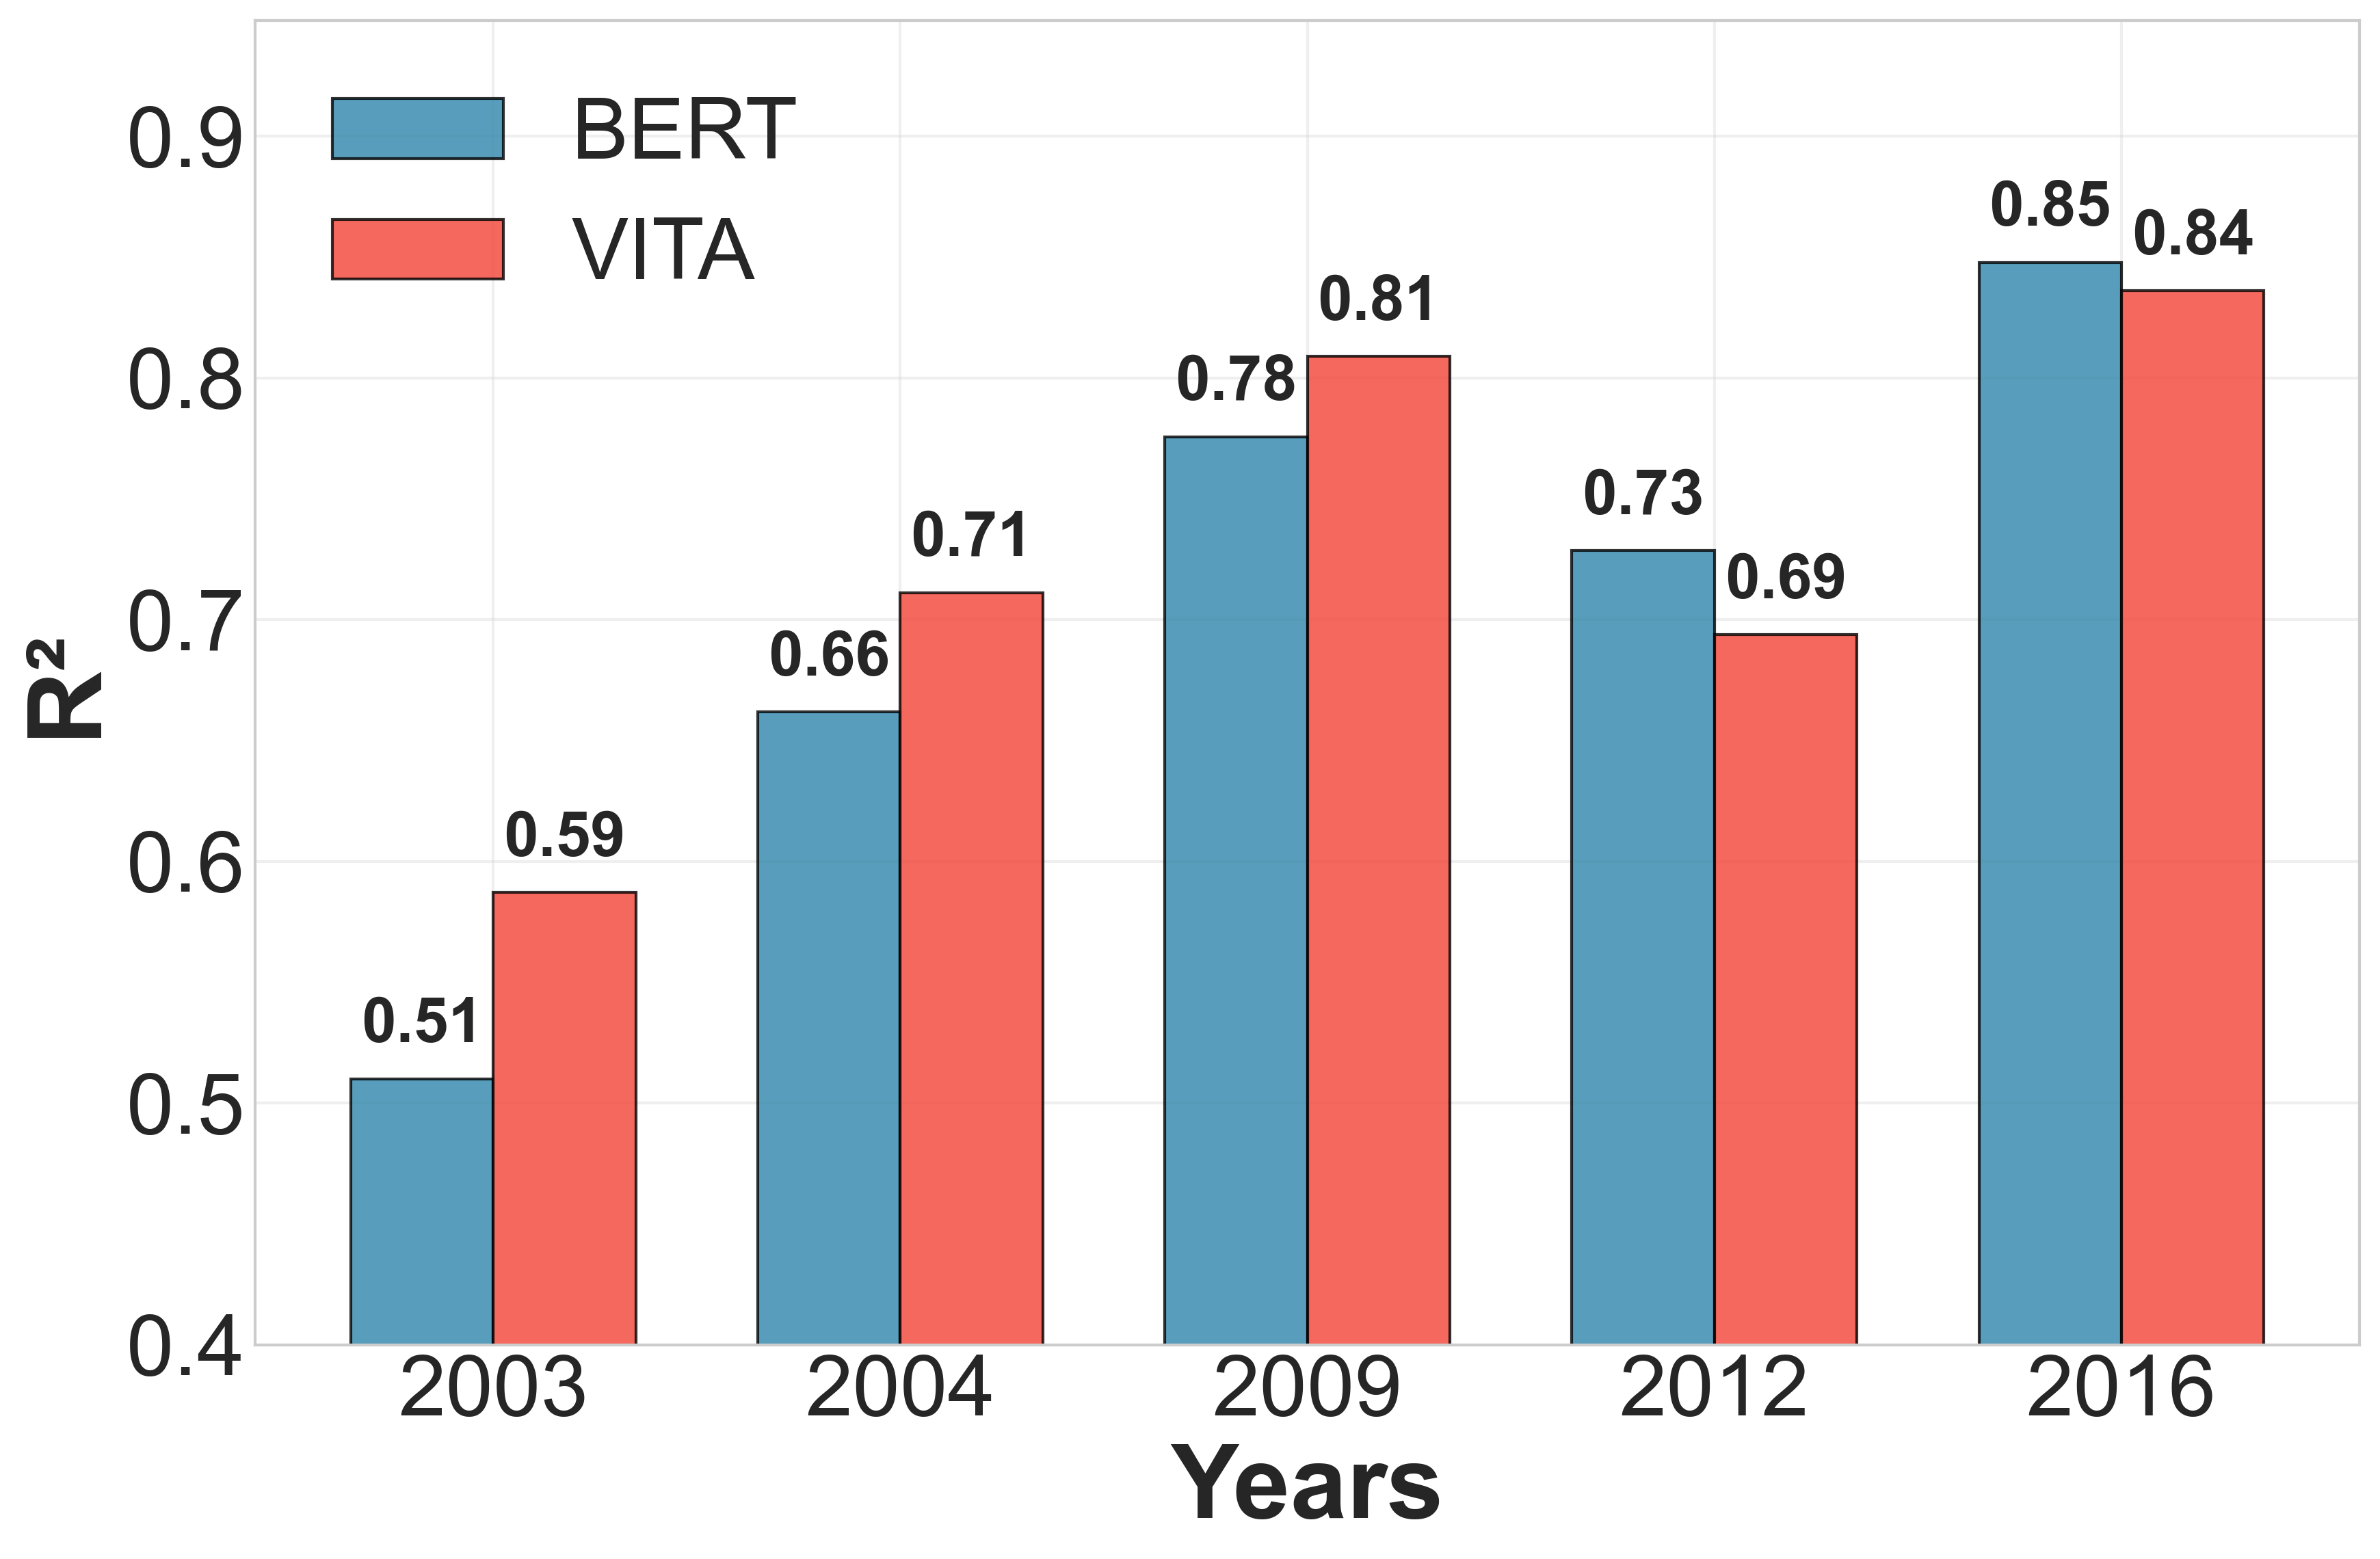

Bar plot saved as '../data/latex/img/individual_r2_comparison_soybean.pdf'


In [85]:
# Create bar plot for individual R² values - neurips style
fig, ax = plt.subplots(figsize=(12, 8))

# Number of folds
n_folds = len(best_bert_individual_r2)
fold_labels = [str(year) for year in EXTREME_YEARS[crop_type]]

# Set up bar positions
x = np.arange(n_folds)
width = 0.35

# Create bars using existing color palette
bars1 = ax.bar(x - width/2, best_bert_individual_r2, width, 
               label='BERT', color=colors['BERT'], alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, best_weatherformer_individual_r2, width, 
               label=model_display_name, color=colors[model_display_name], alpha=0.8, edgecolor='black')

# Add numbers on top of bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}', ha='center', va='bottom', fontsize=22, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}', ha='center', va='bottom', fontsize=22, fontweight='bold')

# Customize the plot - no title for neurips style
ax.set_xlabel('Years')
ax.set_ylabel('R²')
ax.set_xticks(x)
ax.set_xticklabels(fold_labels)
ax.legend()

# Set y-axis limits to better show the data
ax.set_ylim(0.4, max(max(best_bert_individual_r2), max(best_weatherformer_individual_r2)) + 0.1)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'../data/latex/img/individual_r2_comparison_{crop_type}.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"Bar plot saved as '../data/latex/img/individual_r2_comparison_{crop_type}.pdf'")


In [86]:
def table_entry(std, std_rmse):
    r2 = 1-std_rmse**2
    rmse_scaled = std * std_rmse
    return f"{r2:.3f} ({rmse_scaled:.1f})"


entry =  table_entry(10.572, 0.6021)
print(entry)

0.637 (6.4)
